In [1]:
# automatically reloads the libary upon changes, only needed if you change the library
%load_ext autoreload
%autoreload 2

In [2]:
# Import the "predator and prey" library, written by Lu
import pnp

# Import relevant plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Import data libraries
import pandas as pd

In [3]:
# Check the already included "Models"
pnp.models

[pnp.LotkaVolterra,
 pnp.LogisticPrey,
 pnp.ThreePopulations,
 pnp.NicholsonBailey]

In [4]:
# A model is an already prepared simulation with starting populations, constants and functions set

# Construct an object from the SimpleModel Class
model = pnp.LotkaVolterra()

print('simulation parameters', model.simulation_parameters)
# the model's starting populations
print('population', model.population)
# the model's constants
print('constants', model.constants)
# the model's functions (these are already compiled, so printing them won't give you much insight)
print('functions', model.functions)

simulation parameters {'steps': 1000, 'step_size': 0.01, 'compression': 1, 'verbose': True}
population {'rabbit': 1, 'wolf': 1}
constants {'rabbit-r': 1, 'hunt': 1, 'rabbit-value': 1, 'wolf-hunger': 1}
functions {'rabbit': <function LotkaVolterra.set_functions.<locals>.<lambda> at 0x05CC9A00>, 'wolf': <function LotkaVolterra.set_functions.<locals>.<lambda> at 0x049F6B68>}


In [5]:
# Let's run a simulation!

seperate_df, combined_df = model.run_simulation()

100%|██████████| 1000/1000 [00:00<00:00, 418426.18it/s]


In [6]:
# The simulation above returned two "DataFrames", which are basically fancy spreadsheets from the library "pandas"

# Let's look at the output

# The "seperate DataFrame" keeps the different animal populations in different columns
print('Seperate DataFrame')
print(seperate_df)
print('----------------')
# The "combined DataFrame has a row for each animal population in each step and is therefore not very legibile"
print('Combined DataFrame')
print(combined_df)

Seperate DataFrame
       time  rabbit  wolf
0      0.00     1.0   1.0
1      0.01     1.0   1.0
2      0.02     1.0   1.0
3      0.03     1.0   1.0
4      0.04     1.0   1.0
...     ...     ...   ...
996    9.96     1.0   1.0
997    9.97     1.0   1.0
998    9.98     1.0   1.0
999    9.99     1.0   1.0
1000  10.00     1.0   1.0

[1001 rows x 3 columns]
----------------
Combined DataFrame
       time animal_type  animal_number
0      0.00      rabbit            1.0
1      0.00        wolf            1.0
2      0.01      rabbit            1.0
3      0.01        wolf            1.0
4      0.02      rabbit            1.0
...     ...         ...            ...
1997   9.98        wolf            1.0
1998   9.99      rabbit            1.0
1999   9.99        wolf            1.0
2000  10.00      rabbit            1.0
2001  10.00        wolf            1.0

[2002 rows x 3 columns]


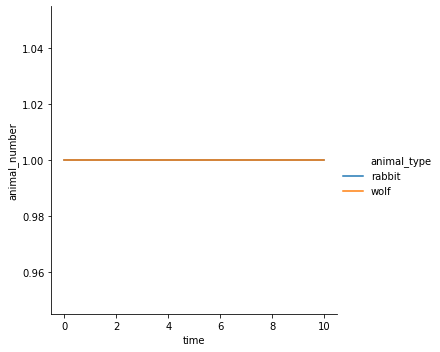

In [7]:
# The strength of the combined DataFrame will become apparent in plotting

# As is visible, the combined_df (which can be seen in the "data" argument) is very important for plotting
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df)

100%|██████████| 1000/1000 [00:00<00:00, 29169.04it/s]


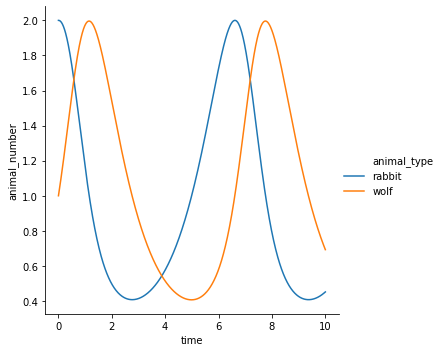

In [8]:
# The plot in the step above does not look right, both rabbit and wolf stay constant
# This is because by default all prebuilt models are IN EQUILIBRIUM, to get any meaningful results you have to change some of the variables

# Let's change some variables

# Starting with double as many rabbits as before
model.population['rabbit'] = 2

seperate_df, combined_df = model.run_simulation() # Running the simulation again
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df) # Plotting

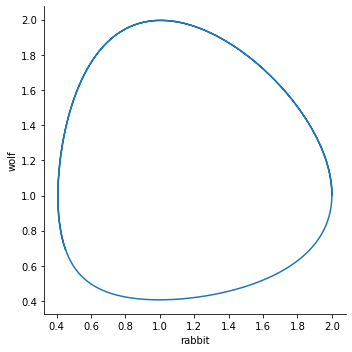

In [9]:
# Another thing one can do is plotting the datapoints in a phase space of "rabbit" and "wolf"

# Note that we use the "seperate" DataFrame for this
sns.relplot(x="rabbit", y="wolf", kind="line", sort=False, data=seperate_df)

100%|██████████| 300/300 [00:00<00:00, 164353.61it/s]


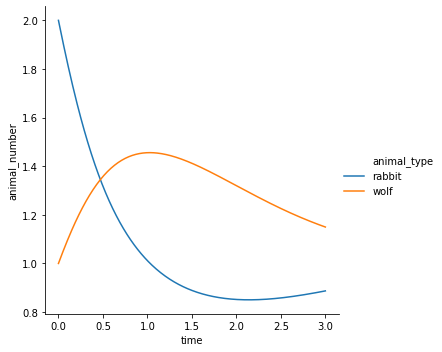

In [10]:
# Other things you may change are


# Simulation Parameters
# These determine for how many steps a simulation runs and how large these steps are
model.simulation_parameters['steps'] = 300

# Constants
# Changing the rabbit reproduction rate from 1 to 1.1
model.constants['rabbit-r'] = 1.1

# Functions (quite complicated)
# Changing it so that a too high rabbit population decreases the population again
model.functions['rabbit'] = lambda population, constants: population['rabbit'] * (constants['rabbit-r'] - constants['hunt'] * population['wolf'] * population['rabbit'])

seperate_df, combined_df = model.run_simulation() # Running the simulation again
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df) # Plotting

100%|██████████| 1000/1000 [00:00<00:00, 199957.28it/s]


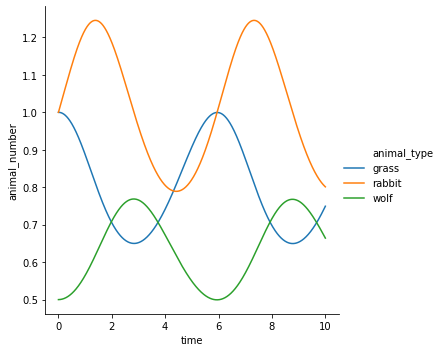

In [11]:
# Creating your own model by setting up the starting conditions

class ThreeAnimals(pnp.Model): # We are using the pnp.Model class as our base

    def set_simulation_parameters(self):
        return {
            'steps': 1000,
            'step_size': 10**-2,
            'compression': 1,
            'verbose': True
        }
    
    def set_population(self):
        return {
        'grass': 1,
        'rabbit': 1,
        'wolf': 1
        }

    def set_constants(self): # constants
        return {
            'grass-r': 1,
            'rabbit-hunt': 1,
            'grass-value': 1,
            'rabbit-hunger': 0.5,
            'wolf-hunt': 0.5,
            'rabbit-value': 1,
            'wolf-hunger': 1
        }

    def set_functions(self): # functions
        return {
            'grass': lambda population, constants: population['grass'] * (constants['grass-r'] - constants['rabbit-hunt'] * population['rabbit']),
            'rabbit': lambda population, constants: population['rabbit'] * (constants['grass-value'] * population['grass'] - constants['rabbit-hunger'] - constants['wolf-hunt'] * population['wolf']),
            'wolf': lambda population, constants: population['wolf'] * (constants['rabbit-value'] * population['rabbit'] - constants['wolf-hunger'])
        }

# This model may now be used like any other model
model = ThreeAnimals()

model.population['wolf'] = 0.5

seperate_df, combined_df = model.run_simulation() # Running the simulation
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df) # Plotting

In [12]:
# If you want to insert the parameters of the model into a LaTeX Document you can do the following

print(model.print_parameters())
# This gives you a valid LaTeX table you can copy paste into your document
# Please note that you need to write the functions yourself

\begin{table}[]
\begin{tabular}{llllllll|}
\hline
\multicolumn{2}{{|l|}}{Simulation} & \multicolumn{2}{l|}{Population} & \multicolumn{2}{l|}{Functions} & \multicolumn{2}{l|}{Constants} \\ \hline
\multicolumn{1}{|l|}{Steps} & \multicolumn{1}{|l|}{1000} & \multicolumn{1}{|l|}{grass} & \multicolumn{1}{|l|}{1} & \multicolumn{1}{|l|}{grass} & \multicolumn{1}{|l|}{$x$} & \multicolumn{1}{|l|}{grass-r} & \multicolumn{1}{|l|}{1} \\ 
\multicolumn{1}{|l|}{Step Size} & \multicolumn{1}{|l|}{0.01} & \multicolumn{1}{|l|}{rabbit} & \multicolumn{1}{|l|}{1} & \multicolumn{1}{|l|}{rabbit} & \multicolumn{1}{|l|}{$x$} & \multicolumn{1}{|l|}{rabbit-hunt} & \multicolumn{1}{|l|}{1} \\ 
\multicolumn{1}{|l|}{Compression} & \multicolumn{1}{|l|}{1} & \multicolumn{1}{|l|}{wolf} & \multicolumn{1}{|l|}{0.5} & \multicolumn{1}{|l|}{wolf} & \multicolumn{1}{|l|}{$x$} & \multicolumn{1}{|l|}{grass-value} & \multicolumn{1}{|l|}{1} \\ \cline{1-2}\cline{3-4}\cline{5-6}
& & & & & & \multicolumn{1}{|l|}{rabbit-hunger} & \multi

100%|██████████| 100000/100000 [00:00<00:00, 348996.89it/s]


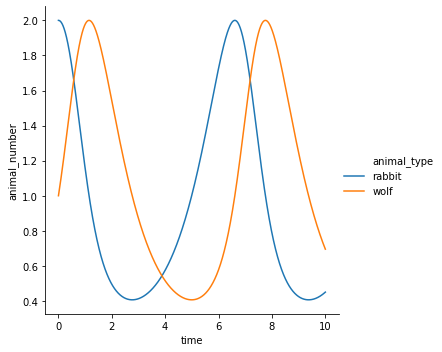

In [13]:
# As you may have noticed/suspected, this library is not perfect at simulating derivatives, it actually overshoots inversly proportional to the stepsize
# But decreasing the stepsize means having to simulate a lot more steps to get the same result
# This can create unwieldy amounts of data, which is why the simulation parameter of "compression" exists

model = pnp.LotkaVolterra()
model.population['rabbit'] = 2 # removing the equilibrium

# Here we set the compression to 10
# This means only saving every xth step!
model.simulation_parameters['compression'] = 10

# Now we can easily run more steps
model.simulation_parameters['steps'] = 10**5
model.simulation_parameters['step_size'] = 10**-4

seperate_df, combined_df = model.run_simulation() # Running the simulation

# Note that the steps * step_size = time
# meaning as long as you keep the ratio between these two constant, you should get about the same curve

# You may notice that running the simulation takes a bit more time

# But due to our compression, plotting is still fast!
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df)

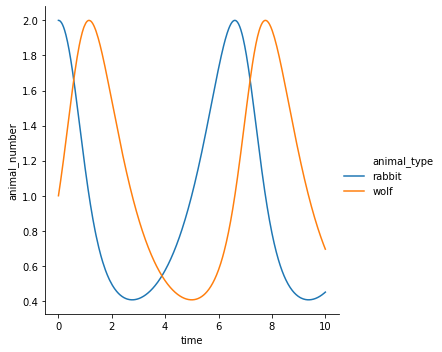

In [14]:
# If you have already generated a dataset and wish to compress it, the pnp package also has the "prune" function

# This reduces the amount of steps by the factor of 10
combined_df = pnp.prune(combined_df, 10)

# Side effects include faster plotting and edgier plots
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df)

# Only consider using "prune" if the compression built into the simulation somehow does not adress your problem

In [15]:
# Generally, the longer your simulation goes on for, the less accurate it becomes
# This in turn means that you have to reduce the step_size even further!

model = pnp.LotkaVolterra()
model.population['rabbit'] = 2

model.simulation_parameters = {
    'steps': 5*10**6,
    'step_size': 10**-5,
    'compression': 10**4,
    'verbose': True
}

# Relatively high accuracy of the simulation, might take a few seconds
readable_df, combined_df = model.run_simulation()

100%|██████████| 5000000/5000000 [00:11<00:00, 421015.06it/s]


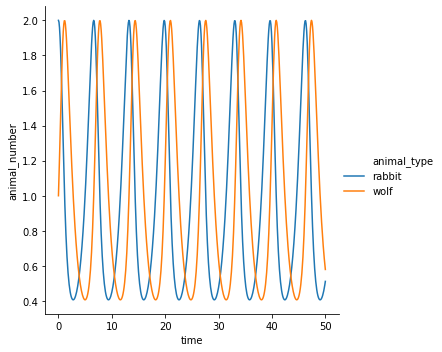

In [16]:
# Plotting reveals that the amplitude (according to the theoretical model) does not change
sns.relplot(x="time", y="animal_number", hue="animal_type", kind='line', data=combined_df)

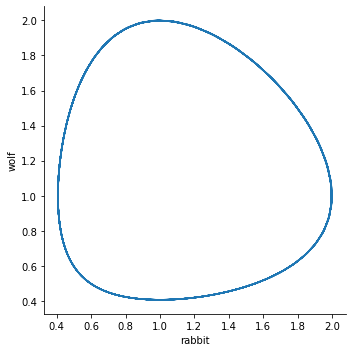

In [17]:
# Plotting rabbits vs wolves reveals a very stable cycle
sns.relplot(x="rabbit", y="wolf", kind="line", sort=False, data=readable_df)

100%|██████████| 50000/50000 [00:00<00:00, 387007.67it/s]


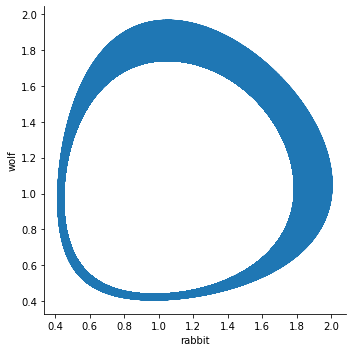

In [18]:
# A less accurate (but faster) simulation to show the danger of the inaccuracies

model = pnp.LotkaVolterra()
model.population['rabbit'] = 2

model.simulation_parameters = {
    'steps': 5*10**4,
    'step_size': 10**-1,
    'compression': 10**1,
    'verbose': True
}

readable_df, combined_df = model.run_simulation()
sns.relplot(x="rabbit", y="wolf", kind="line", sort=False, data=readable_df)

# Attempt to keep the stepsize at 10**-3 or lower! Especially if you are running a longer simulation

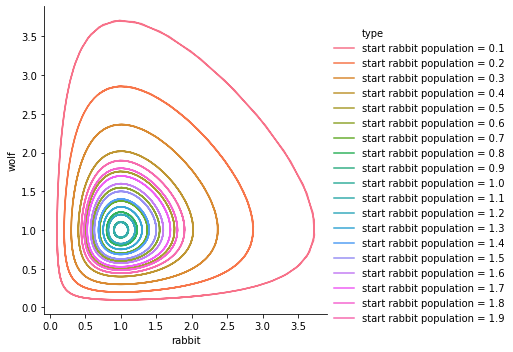

In [19]:
# To find out relationships between different parameters and results, it might be of interest to run a series of simulations
# For this the data class "Model Series" was made

# Defining a simple model
model1 = pnp.LotkaVolterra()
model1.population['rabbit'] = 1
model1.simulation_parameters['steps'] = 2*10**3
model1.simulation_parameters['step_size'] = 10**-2
model1.simulation_parameters['compression'] = 10**1

# As we will be running several simulations after one another, it might be of interest to not print a loading bar for each
# So we set the "verbose" flag to false
model1.simulation_parameters['verbose'] = False

# The ModelSeries Class takes two arguments
# A Model (the model itself will be not changed as the Model Series class saves a copy)
# A series of numbers (or any iterable)
series1 = pnp.ModelSeries(model1, [i/10 for i in range(1, 20)])

# Importantly you also need to define a new "change property" function
# This function is responsible for adjusting the properties of your model every iteration

# self.model is the model you passed to the Series
# self.iter is the series of number you passed to the Series
def change_property(self):
    self.model.population['rabbit'] = next(self.iter)

series1.change_property = change_property

# Now we run several simulations after one another and save their results in our "dfs" list
dfs = []
for seperate_df, combined_df in series1: # Series objects are iterable
    pop = series1.model.population['rabbit'] # Getting the start population of rabbits (which changes every iteration)
    seperate_df['type'] = f'start rabbit population = {pop}' # Labelling the data set
    dfs.append(seperate_df) # adding it to the other dataframes

seperate_df = pd.concat(dfs) # adding all dataframes together into one giant dataframe
sns.relplot(x="rabbit", y="wolf", kind="line", hue="type", sort=False, data=seperate_df) # Plotting the phase space

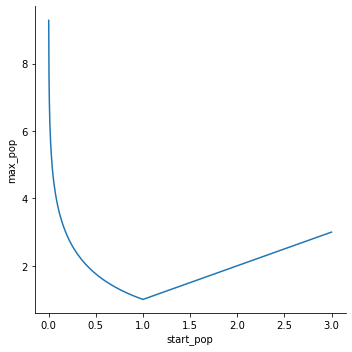

In [20]:
# Here is another example showing the power of Model Series

# Defining the model
model1 = pnp.LotkaVolterra()
model1.population['rabbit'] = 1
model1.simulation_parameters['steps'] = 2*10**3
model1.simulation_parameters['step_size'] = 10**-2
model1.simulation_parameters['compression'] = 10**1
model1.simulation_parameters['verbose'] = False

# This will be running 3000 (!) simulations, so it might take some time
series1 = pnp.ModelSeries(model1, [i/1000 for i in range(1, 3000)])
def change_property(self):
    self.model.population['rabbit'] = next(self.iter)

series1.change_property = change_property

# We now save the starting population of rabbits and the maximum population of rabbits reached
data = {'start_pop': [], 'max_pop': []}
for seperate_df, combined_df in series1:
    pop = series1.model.population['rabbit']
    data['start_pop'].append(pop)
    data['max_pop'].append(seperate_df['rabbit'].max()) # The in-built function of DataFrames to get the maximum value of a column

df = pd.DataFrame(data)
sns.relplot(x="start_pop", y="max_pop", kind="line", sort=False, data=df)